# Kaggle Machine Learning Project
## Porto Seguru's Safe Driver Prediction

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

## Importing Data

In [1]:
# Author: Nicholas Low
# Date Started: 10/14/2017

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Training Data
train_df = pd.read_csv('Data/train.csv')
train_y = train_df['target']
train_x = train_df.drop('target', axis =1)
# Final Submission Test Data
submit_df = pd.read_csv('Data/test.csv')

# Success Check
print "Training dataset has {} rows of data with {} variables each.".format(*train_df.shape)
print "Testing dataset has {} rows of data with {} variables each.".format(*submit_df.shape)

Training dataset has 595212 rows of data with 59 variables each.
Testing dataset has 892816 rows of data with 58 variables each.


## Data Exploration
There are 58 features and 1 target. The target value is listed as 'target'. The other input variables consist of 58 variables that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

In [2]:
train_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### Variable Identification

In [3]:
features = list(train_df)
merge_features = '-'.join(features)
print train_df.dtypes
print '# of binary and categorical features respectively ' + str(merge_features.count('bin')) + ' and ' + str(merge_features.count('cat'))
print '# of continous or ordinal features is '+ str(58-(17+14)) + ' and 10 are continous and 17 are ordinal'

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

In [11]:
bin_df = train_x.filter(like='bin', axis =1)
#Grab all categorical data
cat_df = train_x.filter(like='cat', axis =1)
#Grab all continuous data
cont_df = train_x.select_dtypes(include=['float64'])
#Grab all ordinal data
ord_df = train_x[train_x.columns.difference(list(bin_df)+list(cat_df)+list(cont_df))]

print cat_df.mode()

   ps_ind_02_cat  ps_ind_04_cat  ps_ind_05_cat  ps_car_01_cat  ps_car_02_cat  \
0              1              0              0             11              1   

   ps_car_03_cat  ps_car_04_cat  ps_car_05_cat  ps_car_06_cat  ps_car_07_cat  \
0             -1              0             -1             11              1   

   ps_car_08_cat  ps_car_09_cat  ps_car_10_cat  ps_car_11_cat  
0              1              2              1            104  


### Univariate Analysis

In [5]:
cont_df.describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001921ABA8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001D84FD68>]], dtype=object)

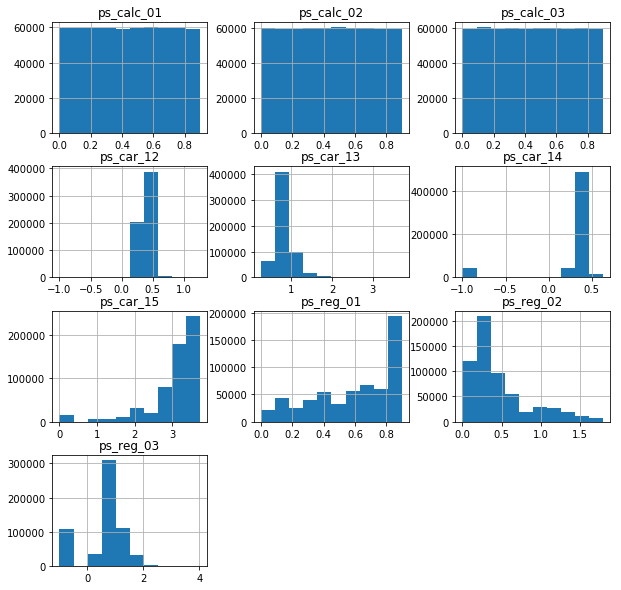

In [7]:
#Histogram of continuous value to see distribution of values
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
cont_df.hist(ax=ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000121F4A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000010AA7278>]], dtype=object)

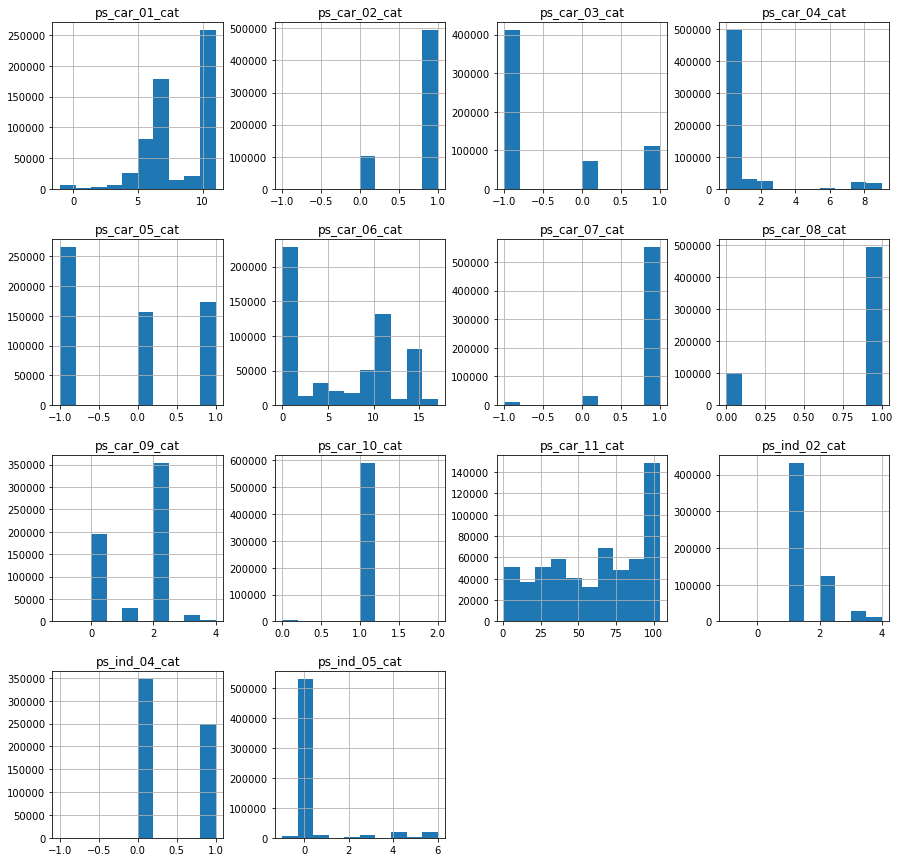

In [8]:
fig1 = plt.figure(figsize = (15,15))
ax1 = fig1.gca()
cat_df.hist(ax=ax1)

### Bivariate Analysis

Correlation Analysis: Features should be uncorrelated with each other otherwise one of the features isn't adding that much more to your model. Features correlating with the target variable add more to the model.

In [9]:
print train_df.corr()

                      id    target  ps_ind_01  ps_ind_02_cat  ps_ind_03  \
id              1.000000 -0.000188   0.000826       0.001646  -0.001307   
target         -0.000188  1.000000   0.018570       0.004534   0.008360   
ps_ind_01       0.000826  0.018570   1.000000      -0.001793   0.223408   
ps_ind_02_cat   0.001646  0.004534  -0.001793       1.000000  -0.061189   
ps_ind_03      -0.001307  0.008360   0.223408      -0.061189   1.000000   
ps_ind_04_cat   0.000168  0.009360   0.066645       0.147110  -0.095856   
ps_ind_05_cat   0.000022  0.029165   0.014823      -0.014860   0.053250   
ps_ind_06_bin  -0.000093 -0.034017  -0.277458      -0.125653  -0.045158   
ps_ind_07_bin   0.002473  0.034218   0.005700       0.016398  -0.060368   
ps_ind_08_bin  -0.000479  0.013147   0.188583       0.030945   0.014037   
ps_ind_09_bin  -0.002208 -0.008237   0.162800       0.110076   0.111306   
ps_ind_10_bin  -0.001261  0.001815   0.001847      -0.000744   0.006865   
ps_ind_11_bin  -0.001210 

## Feature Cleaning
### Missing Values

In [22]:
print cont_df.min(), cat_df.min(), bin_df.min(), ord_df.min()

#Replace continuous data with the mean
cont_df = cont_df.replace(-1.0, cont_df.mean())

#No missing values in bin and replace categorical and ordinal data with mode
cat_mode = cat_df.replace(-1.0, np.NaN).mode()
cat_df = cat_df.replace(-1.0, cat_mode)
ord_mode = ord_df.replace(-1.0, np.NaN).mode()
ord_df = ord_df.replace(-1.0, ord_mode)

ps_reg_01     0.000000
ps_reg_02     0.000000
ps_reg_03     0.061237
ps_car_12     0.100000
ps_car_13     0.250619
ps_car_14     0.109545
ps_car_15     0.000000
ps_calc_01    0.000000
ps_calc_02    0.000000
ps_calc_03    0.000000
dtype: float64 ps_ind_02_cat    1
ps_ind_04_cat    0
ps_ind_05_cat    0
ps_car_01_cat    0
ps_car_02_cat    0
ps_car_03_cat    0
ps_car_04_cat    0
ps_car_05_cat    0
ps_car_06_cat    0
ps_car_07_cat    0
ps_car_08_cat    0
ps_car_09_cat    0
ps_car_10_cat    0
ps_car_11_cat    1
dtype: int64 ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_calc_15_bin    0
ps_calc_16_bin    0
ps_calc_17_bin    0
ps_calc_18_bin    0
ps_calc_19_bin    0
ps_calc_20_bin    0
dtype: int64 id            7
ps_calc_04    0
ps_calc_05    0
ps_calc_06    0
ps_calc_07    0
ps_calc_08    2
ps_calc_09    0
ps_calc_10 